In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

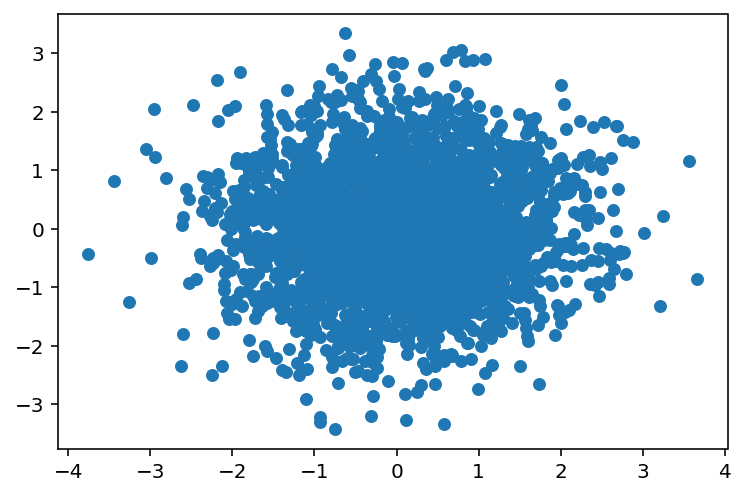

In [2]:
# Generate some data

X = np.random.randn(3000, 2)

# Plot the data

plt.scatter(X[:, 0], X[:, 1], s=30)

In [4]:
# Naive KNN

def naive_knn_for_loop(X, x_test, k=3):
    dists = np.zeros(X.shape[0])
    for i in range(X.shape[0]): # N iterations (N = number of data points)
        dists[i] = np.dot(X[i] - x_test, X[i] - x_test) # Time complexity: O(D)
    
    # Time complexity to create the distance array: O(N*D)

    # Now, we need to find the k smallest distances
    return np.argpartition(dists, k)[:k] # Time complexity: O(Nk) or O(N) depending on the implementation
  

In [5]:
naive_knn_for_loop(X, np.array([0, 0]))

array([2529,  958,  804])

In [6]:
X[naive_knn_for_loop(X, np.array([0, 0]))]

array([[-0.02103967,  0.02703294],
       [ 0.0092843 ,  0.02548091],
       [-0.03094897,  0.01750535]])

In [7]:
%timeit naive_knn_for_loop(X, np.array([0, 0]))

12.3 ms ± 47.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# Implement using numpy

def naive_knn_numpy(X, x_test, k=3):
    dists = np.sum((X - x_test)**2, axis=1)
    #return np.partition(dists, k)[:k]
    sorted_dists = np.argsort(dists)
    return sorted_dists[:k]


In [9]:
naive_knn_numpy(X, np.array([0, 0]))

array([ 958, 2529,  804])

In [10]:
%timeit naive_knn_numpy(X, np.array([0, 0]))

240 µs ± 631 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
# Implement using numpy

def naive_knn_numpy(X, x_test, k=3):
    dists = np.sum((X - x_test)**2, axis=1)
    return np.argpartition(dists, k)[:k]
    #sorted_dists = np.argsort(dists)
    #return sorted_dists[:k]


In [12]:
%timeit naive_knn_numpy(X, np.array([0, 0]))

84.6 µs ± 607 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


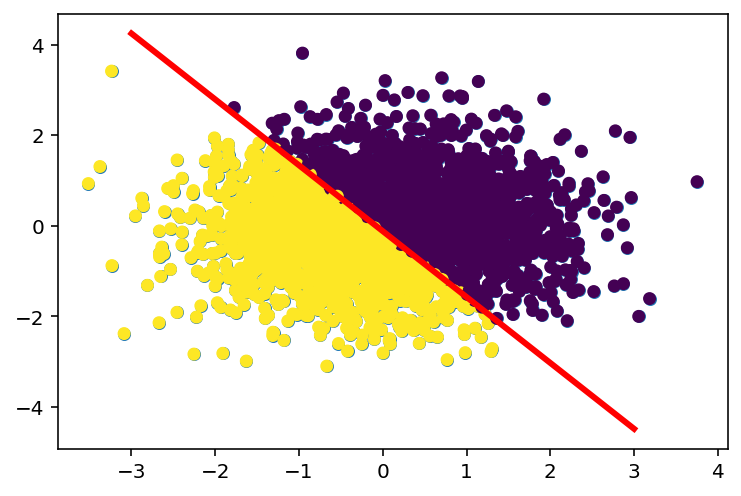

In [13]:
# Show LSH implementation step by step

# Creating a random separating hyperplane

w = np.random.randn(2)
b = np.random.randn(1)/4.0

# Plot the separating hyperplane

x = np.linspace(-3, 3, 100)
y = -(w[0] * x + b) / w[1]

plt.scatter(X[:, 0], X[:, 1], s=30)
plt.plot(x, y, 'r', linewidth=3)

# Color the points based on which side of the hyperplane they are on

colors = X[:, 0]*w[0] + X[:, 1]*w[1] + b > 0

plt.scatter(X[:, 0], X[:, 1], s=30, c=colors)

[-1.78798897 -1.3408181 ] [-0.08094113]
[ 0.9447324  -2.47059549] [0.09350769]
[0.20531227 0.97521902] [-0.22471283]


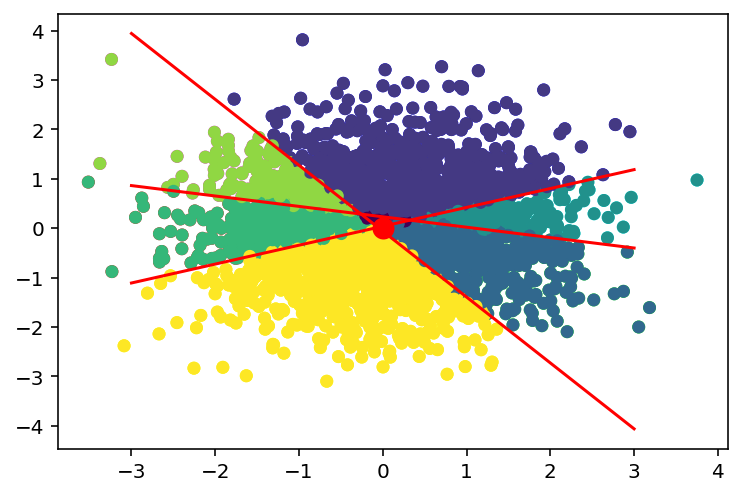

In [15]:
# Create three random hyperplanes and color the points based on which side of the hyperplane they are on. 
# there should be 2^3 = 8 different colors
# each separating hyperplane corresponds to a bit in the hash

hash = np.zeros((X.shape[0], 3)).astype(int)
ws = []
bs = []
# Cost for creating the hash table: O(N*H*D) 
for H in range(3): # H = number of hyperplanes
    w = np.random.randn(2)
    b = np.random.randn(1)/4.0
    ws.append(w)
    bs.append(b)
    hash[:, H] = X[:, 0]*w[0] + X[:, 1]*w[1] + b > 0 # D computations per iteration

# Convert the hash to a decimal number

hash_dec = np.sum(hash * 2**np.arange(3)[::-1], axis=1)

# Plot the hash

plt.scatter(X[:, 0], X[:, 1], s=30, c=hash)

# Plot the hash with the separating hyperplanes

plt.scatter(X[:, 0], X[:, 1], s=30, c=hash_dec)
for w, b in zip(ws, bs):
    print(w, b)
    x = np.linspace(-3, 3, 100)
    y = -(w[0] * x + b) / w[1]
    plt.plot(x, y, 'r')

# Mark the test point

x_test = np.array([0, 0])
plt.scatter(x_test[0], x_test[1], s=100, c='r')

In [16]:
df = pd.DataFrame(hash)
df.columns = ['h1', 'h2', 'h3']
df['hash_dec'] = hash_dec
df['x'] = X[:, 0]
df['y'] = X[:, 1]

df.head(10)


,h1,h2,h3,hash_dec,x,y
0,1,1,0,6,-1.289013,-0.497073
1,1,1,0,6,0.721631,-1.923390
2,1,1,0,6,0.042595,-0.177549
3,1,1,0,6,0.148706,-0.452442
4,1,1,0,6,-0.047372,-0.431685
5,1,1,0,6,-0.478764,-0.304759
6,0,1,0,2,0.812057,-0.574337
7,1,0,1,5,-1.493164,1.209339
8,0,1,0,2,0.820065,-0.575965
9,0,0,1,1,1.045276,1.143788


In [17]:

pd.DataFrame(hash).value_counts()

0  1  2
1  1  0    846
0  0  1    827
   1  0    491
1  0  0    346
      1    243
0  1  1    210
   0  0     37
dtype: int64

In [18]:
# Predict the K nearest neighbors using LSH

# Compute the hash for the test point

x_test = np.array([0, 0])
hash_test = x_test[0]*ws[0][0] + x_test[1]*ws[0][1] + bs[0] > 0

#convert to decimal
hash_test_dec = np.sum(hash_test * 2**np.arange(3)[::-1])

hash_test_dec

0

In [19]:
# Find subset of points with the same hash

X_subset = X[hash_dec == hash_test_dec]
X_subset.shape

(37, 2)

In [20]:
# Now, we can use the naive KNN implementation to find the K nearest neighbors

ix = naive_knn_numpy(X_subset, x_test, k=3)
X_subset[ix]

array([[-0.04090763,  0.07013394],
       [-0.00419256,  0.08614131],
       [-0.05284791,  0.06786371]])

In [21]:
%timeit naive_knn_numpy(X_subset, x_test, k=3)

10.5 µs ± 31.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [22]:
# Using FAISS from Facebook

import faiss

# Create an index
index = faiss.IndexFlatL2(2)   # build the index

# Add the data to the index
index.add(X.astype(np.float32))                  # add vectors to the index


In [23]:
# Search for the K nearest neighbors
D, I = index.search(x_test.astype(np.float32).reshape(1, -1), k=3)     # actual search


In [24]:
D

array([[0.00073547, 0.00117345, 0.00126428]], dtype=float32)

In [25]:
I

array([[ 958, 2529,  804]])

In [26]:
X[I[0]]

array([[ 0.0092843 ,  0.02548091],
       [-0.02103967,  0.02703294],
       [-0.03094897,  0.01750535]])

In [27]:
%timeit index.search(x_test.astype(np.float32).reshape(1, -1), k=3)

50.9 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
# Now, run on GPU

res = faiss.StandardGpuResources()  # use a single GPU

# Create an index
index = faiss.IndexFlatL2(2)   # build the index

gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index)

# Add the data to the index
gpu_index_flat.add(X.astype(np.float32))                  # add vectors to the index


In [29]:
%timeit gpu_index_flat.search(x_test.astype(np.float32).reshape(1, -1), k=3)

79.8 µs ± 674 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# The above is slow because
# 1. We are copying the data to the GPU
# 2. We are copying the data back to the CPU
# 3. Not enough data and low dimensional data